In [6]:
import pandas as pd
import numpy as np

import sys, os

sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam
from backtester.swarms.manager import SwarmManager
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo

In [7]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [13]:
EXO_File = 'strategy_270225'

strategyname_global = EXO_File
d, info = matlab.loaddata('../../mat/'+strategyname_global+'.mat')

In [14]:
px_ser = d['exo'].ix['2015':]

### Ichi cloud indicator calc
### New version

In [15]:
'''
Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2)) 

The default setting is 9 periods and can be adjusted. On a daily 
chart, this line is the mid point of the 9 day high-low range, 
which is almost two weeks. 
'''
conversion_line_period = 9 # subject of optimization

conversion_line_high = px_ser.rolling(window=conversion_line_period).max()
conversion_line_low = px_ser.rolling(window=conversion_line_period).min()

conversion_line = (conversion_line_high + conversion_line_low) / 2

'''
Kijun-sen (Base Line): (26-period high + 26-period low)/2)) 

The default setting is 26 periods and can be adjusted. On a daily 
chart, this line is the mid point of the 26 day high-low range, 
which is almost one month).
'''
base_line_period = 26 # subject of optimization

base_line_high = px_ser.rolling(window=base_line_period).max()
base_line_low = px_ser.rolling(window=base_line_period).min()

base_line = (base_line_high + base_line_low) / 2

'''
Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2)) 

This is the midpoint between the Conversion Line and the Base Line. 
The Leading Span A forms one of the two Cloud boundaries. It is 
referred to as "Leading" because it is plotted 26 periods in the future
and forms the faster Cloud boundary. 
'''
leading_span_lookahead_period = 26 # subject of optimization
leading_span_a = ((conversion_line + base_line) / 2).shift(leading_span_lookahead_period)

# straightforward time shifting to 'leading_span_lookahead_period' number of days
#leading_span_a.index = leading_span_a.index + pd.DateOffset(days=leading_span_lookahead_period)

'''
Senkou Span B (Leading Span B): (52-period high + 52-period low)/2)) 

On the daily chart, this line is the mid point of the 52 day high-low range, 
which is a little less than 3 months. The default calculation setting is 
52 periods, but can be adjusted. This value is plotted 26 periods in the future 
and forms the slower Cloud boundary.
'''
leading_span_b_period = 52 # subject of optimization
leading_span_b = ((px_ser.rolling(window=leading_span_b_period).max() + 
                   px_ser.rolling(window=leading_span_b_period).min()) / 2).shift(leading_span_lookahead_period)

# straightforward time shifting to 'leading_span_lookahead_period' number of days
#leading_span_b.index = leading_span_b.index + pd.DateOffset(days=leading_span_lookahead_period)

'''
Chikou Span (Lagging Span): Close plotted 26 days in the past
The default setting is 26 periods, but can be adjusted.
'''
lagging_span_periods = 26 # subject of optimization
lagging_span = px_ser.shift(-lagging_span_periods)

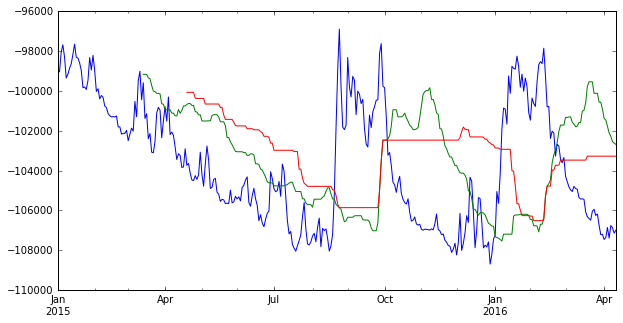

In [16]:
figsize(10,5)
px_ser.plot()
leading_span_a.plot()
leading_span_b.plot()
#lagging_span.plot()

## Rules

In [17]:
# Cloud top and bottom series are defined using leading span A and B
cloud_top = leading_span_a.combine(leading_span_b, max, 0)
cloud_bottom = leading_span_a.combine(leading_span_b, min, 0)

In [18]:
# 1) cloud color red
# 2) cloud color green
cloud_color_green = leading_span_a > leading_span_b
cloud_color_red = leading_span_a < leading_span_b

In [19]:
# It must be a separate variables for rules or?

# 3) price is above cloud top
# 4) price is above cloud bottom

# Style? rule_.... ?
rule_price_above_cloud_top = px_ser > cloud_top 
rule_price_above_cloud_bottom = px_ser > cloud_bottom

# 5) price is below cloud top
# 6) price is below cloud bottom
rule_price_below_cloud_top = px_ser < cloud_top
rule_price_below_cloud_bottom = px_ser < cloud_bottom

# 7) conversion and base line crossings
rule_conv_crossup_base_line = CrossUp(conversion_line, base_line)
rule_conv_crossdown_base_line = CrossDown(conversion_line, base_line)

# 8) price and base line crossings
rule_price_crossup_base_line = CrossUp(px_ser, base_line)
rule_price_crossdown_base_line = CrossDown(px_ser, base_line)

# 9) price and conversion line crossings
rule_price_crossup_conv_line = CrossUp(px_ser, conversion_line)
rule_price_crossdown_conv_line = CrossDown(px_ser, conversion_line)

# 10) is price IN the cloud
rule_price_in_cloud = (px_ser < cloud_top) & (px_ser > cloud_bottom)

# 11) spans crossing
rule_spans_crossup = CrossUp(leading_span_a, leading_span_b)
rule_spans_crossdown = CrossDown(leading_span_a, leading_span_b)

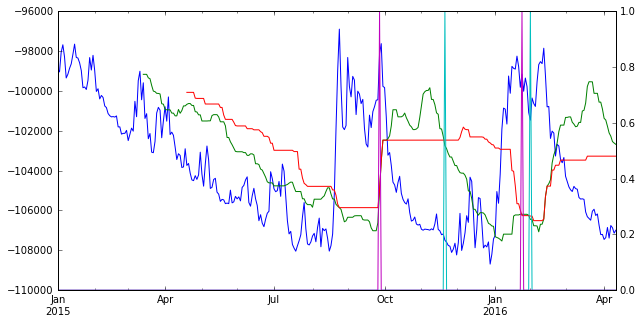

In [20]:
figsize(10,5)
px_ser.plot()

#conversion_line.plot()
#base_line.plot()

leading_span_a.plot()
leading_span_b.plot()

rule_spans_crossdown.plot(secondary_y=True)
rule_spans_crossup.plot(secondary_y=True)
#cloud_color_red.plot(secondary_y=True)

## Old version

In [21]:
 print('Populating IchiMoku Cloud')
        if params is None:
            # Return default parameters
            conversion_line_period, base_line_period, leading_spanB_period, median_period = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            conversion_line_period, base_line_period, leading_spanB_period, median_period = params

        self.conversion_line_period = conversion_line_period
        self.base_line_period = base_line_period
        self.leading_spanB_period = leading_spanB_period
        self.median_period = median_period

        data = self.data

        if False:
            ldates = pd.Series.tolist(pd.to_datetime(data['Date']))
            lclose = pd.Series.tolist(pd.to_numeric(data['Close']))
            lhigh = pd.Series.tolist(pd.to_numeric(data['High']))
            llow = pd.Series.tolist(pd.to_numeric(data['Low']))

            self.dates = pd.Series(ldates)
            self.close = pd.Series(lclose, ldates)
            high = pd.Series(lhigh, ldates)
            low = pd.Series(llow, ldates)

        if True:
            self.close = data['exo']
            high = self.close
            low = self.close

        conversion_high = high.rolling(window=conversion_line_period).max()
        conversion_low = low.rolling(window=conversion_line_period).min()
        self.conversion_line = (conversion_high + conversion_low) / 2.0

        base_high = high.rolling(window=base_line_period).max()
        base_low = low.rolling(window=base_line_period).min()
        self.base_line = (base_high + base_low) / 2.0

        self.leading_spanA = ((self.conversion_line + self.base_line) / 2.0).shift(base_line_period)

        leading_spanB_high = high.rolling(window=leading_spanB_period).max()
        leading_spanB_low = low.rolling(window=leading_spanB_period).min()
        leading_spanB_trace = (leading_spanB_high + leading_spanB_low) / 2.0
        self.leading_spanB = leading_spanB_trace.shift(base_line_period)

        self.lagging_span = self.close.shift(-base_line_period)

        self.cloud_colour = self.leading_spanA > self.leading_spanB
ef calculate(self, params=None):

        self.populate(params)

        dates = self.dates
        close = self.close
        conversion_line = self.conversion_line
        base_line = self.base_line
        leading_spanA = self.leading_spanA
        leading_spanB = self.leading_spanB
        lagging_span = self.lagging_span

        # Cloud top and bottom series are defined using leading span A and B
        cloud_top = leading_spanA.combine(leading_spanB, max, 0)
        cloud_bottom = leading_spanA.combine(leading_spanB, min, 0)

        # ENTRY CALCULATIONS

        # cloud colour should be RED (leading span A is above leading span B)
        cloud_red_cond = ~self.cloud_colour

        # close price should be below cloud bottom (risky but very immediate signal)
        price_cond = close.lt(cloud_bottom)

        # convergence line should be below base line
        conv_base_crossover_cond = conversion_line < base_line
        # base line should be below cloud bottom
        base_line_cond = base_line.lt(cloud_bottom)

        # lagging line should be below cloud bottom (more confirmed but delayed signal)
        lagging_span_cond = lagging_span.lt(cloud_bottom)

        # BUY CONDITION based upon all the above conditions (STRONG BULLISH SIGNAL)
        buy = cloud_red_cond & price_cond & conv_base_crossover_cond & base_line_cond & lagging_span_cond
        # buy = price_cond & conv_base_crossover_cond


        # ENTRY RULE: buy condition turn False to True
        entry_rule = buy & ((~buy).shift(1))

        # EXIT CALCULATIONS

        # conv_base_counter_crossover_cond = conversion_line < base_line

        # Median based trailing stop
        period_median = self.median_period
        trailing_stop = close.rolling(period_median).median().shift(1)

        # EXIT RULE
        exit_rule = ((CrossUp(conversion_line, base_line)) | (CrossUp(lagging_span, cloud_top)))
        # | (CrossUp(close, trailing_stop)))

        sell = exit_rule & buy.shift(1)
        # entry price
        self.buy_price = close.loc[entry_rule == True]
        # exit price
        self.sell_price = close.loc[sell == True]
        # print (self.buy_price)
        # print(price_cond, conv_base_crossover_cond , base_line_cond, lagging_span_cond , buy)
        swarm_member_name = str((self.conversion_line_period, self.base_line_period,
                                 self.leading_spanB_period, self.median_period))

        return swarm_member_name, entry_rule, exit_rule

IndentationError: unexpected indent (<ipython-input-21-b3f377a504f5>, line 2)

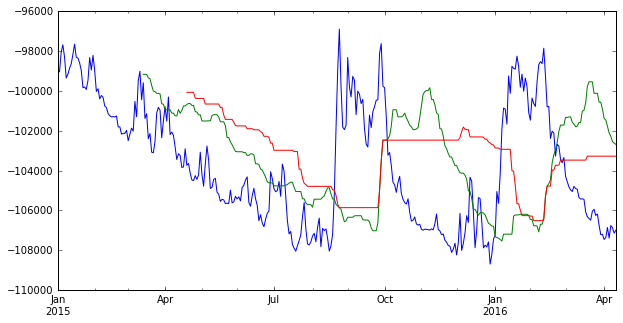

In [111]:
figsize(10,5)
px_ser.plot()
leading_span_a.plot()
leading_span_b.plot()
#lagging_span.plot()

In [168]:
np.arange(18)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])